# PCA & Modeling

---

Nate Bukowski

In [ ]:
# Imports
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

# sklearn imports
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline
from sklearn.metrics import confusion_matrix, plot_confusion_matrix, roc_auc_score

%matplotlib inline

In [5]:
master = pd.read_csv('./cvec_master.csv')

In [6]:
master.head()

,date,latitude,longitude,tone,1000,1014,1024,1026,1039,1041,...,zambezi,zambian,zealander,zealanders,zika,zimbabwean,zimbabweans,zinc,zones,zoroastrians
0,2020-01-01,43.0855,129.30200,2.279202,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,2020-01-01,35.0000,105.00000,0.335570,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,2020-01-01,21.0333,105.85000,-4.919786,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,2020-01-01,43.1346,-6.89444,-1.873199,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,2020-01-01,-24.3167,-47.00000,-4.449649,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [19]:
# Create 'months' column
master['date'] = pd.to_datetime(master['date'])
months = [date.month for date in master['date']]
master['months'] = months

In [20]:
# Define X and y 
X = master.drop(columns=['date', 'months'])
y = master['months']

In [21]:
# Train/test split
X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    test_size = 0.33,
                                                    stratify = y,
                                                    random_state = 6)

## PCA
---

In [25]:
# Instantiate StandardScaler & PCA
ss = StandardScaler()
pca = PCA(random_state=6)

# Fit & transform X_train
X_train = ss.fit_transform(X_train)

# Transform X_test
X_test = ss.transform(X_test)

# Fit & transform PCA
Z_train = pca.fit_transform(X_train)
Z_test = pca.transform(X_test)

In [27]:
# Adapted from code written by Matt Brems (8.03-lesson-principal-component-analysis)

# Pull the explained variance attribute.
var_exp = pca.explained_variance_ratio_
print(f'Explained variance (first 50 components): {np.round(var_exp[:50], 3)}')

print('')

# Generate the cumulative explained variance.
cum_var_exp = np.cumsum(var_exp)
print(f'Cumulative explained variance (first 50 components): {np.round(cum_var_exp[:50], 3)}')

Explained variance (first 50 components): [0.021 0.014 0.013 0.012 0.011 0.011 0.01  0.009 0.009 0.009 0.009 0.008
 0.008 0.008 0.008 0.008 0.008 0.007 0.007 0.007 0.007 0.007 0.006 0.006
 0.006 0.006 0.006 0.006 0.006 0.006 0.006 0.006 0.006 0.006 0.005 0.005
 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005 0.005
 0.005 0.005]

Cumulative explained variance (first 50 components): [0.021 0.035 0.048 0.059 0.07  0.081 0.09  0.1   0.109 0.118 0.127 0.135
 0.144 0.152 0.16  0.167 0.175 0.182 0.189 0.196 0.203 0.21  0.216 0.223
 0.229 0.235 0.241 0.247 0.253 0.259 0.264 0.27  0.275 0.281 0.286 0.292
 0.297 0.302 0.308 0.313 0.318 0.323 0.328 0.333 0.337 0.342 0.347 0.352
 0.356 0.361]


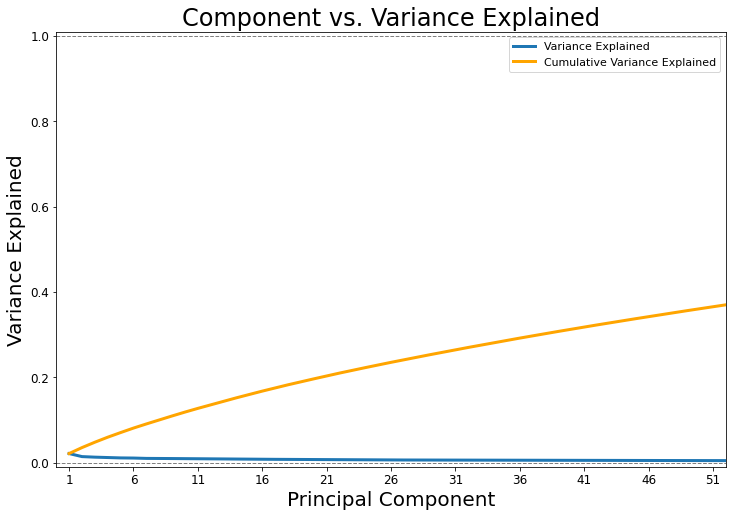

In [29]:
# Adapted from code written by Matt Brems (8.03-lesson-principal-component-analysis)
# Plot the variance explained (and cumulative variance explained).

# Set figure size.
plt.figure(figsize=(12,8))

# Plot the explained variance.
plt.plot(range(len(var_exp)), var_exp, lw=3, label = 'Variance Explained')

# Plot the cumulative explained variance.
plt.plot(range(len(var_exp)), cum_var_exp, lw=3, color = 'orange', label = 'Cumulative Variance Explained')

# Add horizontal lines at y=0 and y=1.
plt.axhline(y=0, linewidth=1, color='grey', ls='dashed')
plt.axhline(y=1, linewidth=1, color='grey', ls='dashed')

# Set the limits of the axes.
plt.xlim([-1,51])
plt.ylim([-0.01,1.01])

# Label the axes.
plt.ylabel('Variance Explained', fontsize=20)
plt.xlabel('Principal Component', fontsize=20)

# Make the tick labels bigger
plt.xticks(range(0, 51, 5), range(1, 52, 5), fontsize=12)
plt.yticks(fontsize=12)
    
# Add title and legend.
plt.title('Component vs. Variance Explained', fontsize=24)
plt.legend(fontsize=11);

## Modeling

---

In [46]:
# KNN Pipeline

knn_pipe = Pipeline([
    ('pca', PCA(random_state=6)),
    ('knn', KNeighborsClassifier())
])

knn_params = {
    'pca__n_components': [15, 30, 50, 100],
    'knn__n_neighbors': [5, 15, 25]
}


knn_gs = GridSearchCV(knn_pipe,
                      knn_params,
                      cv=5)

knn_gs.fit(X_train, y_train)

GridSearchCV(cv=5, error_score=nan,
             estimator=Pipeline(memory=None,
                                steps=[('pca',
                                        PCA(copy=True, iterated_power='auto',
                                            n_components=None, random_state=6,
                                            svd_solver='auto', tol=0.0,
                                            whiten=False)),
                                       ('knn',
                                        KNeighborsClassifier(algorithm='auto',
                                                             leaf_size=30,
                                                             metric='minkowski',
                                                             metric_params=None,
                                                             n_jobs=None,
                                                             n_neighbors=5, p=2,
                                                             weig

In [47]:
# Logistic Regression Pipeline

logreg_pipe = Pipeline([
    ('pca', PCA(random_state=6)),
    ('logreg', LogisticRegression(solver='lbfgs', max_iter=10_000))
])

logreg_params = {
    'pca__n_components': [15, 30, 50, 100]
}


logreg_gs = GridSearchCV(logreg_pipe,
                         logreg_params,
                         cv=5)

logreg_gs.fit(X_train, y_train)

GridSearchCV(cv=5, error_score=nan,
             estimator=Pipeline(memory=None,
                                steps=[('pca',
                                        PCA(copy=True, iterated_power='auto',
                                            n_components=None, random_state=6,
                                            svd_solver='auto', tol=0.0,
                                            whiten=False)),
                                       ('logreg',
                                        LogisticRegression(C=1.0,
                                                           class_weight=None,
                                                           dual=False,
                                                           fit_intercept=True,
                                                           intercept_scaling=1,
                                                           l1_ratio=None,
                                                           max_iter=10000,
          

In [67]:
# Random Forest Pipeline

rf_pipe = Pipeline([
    ('pca', PCA(random_state=6)),
    ('rf', RandomForestClassifier(random_state=6))
])

rf_params = {
    'pca__n_components': [15, 30, 50, 100],
    'rf__n_estimators': [50, 100],
    'rf__max_depth': [None, 25, 100],
    'rf__max_features': [None, 'auto']
}


rf_gs = GridSearchCV(rf_pipe,
                     rf_params,
                     cv=5)

rf_gs.fit(X_train, y_train)

GridSearchCV(cv=5, error_score=nan,
             estimator=Pipeline(memory=None,
                                steps=[('pca',
                                        PCA(copy=True, iterated_power='auto',
                                            n_components=None, random_state=6,
                                            svd_solver='auto', tol=0.0,
                                            whiten=False)),
                                       ('rf',
                                        RandomForestClassifier(bootstrap=True,
                                                               ccp_alpha=0.0,
                                                               class_weight=None,
                                                               criterion='gini',
                                                               max_depth=None,
                                                               max_features='auto',
                                                      

In [73]:
# SVC Pipeline

svc_pipe = Pipeline([
    ('pca', PCA(random_state=6)),
    ('svc', SVC())
])

svc_params = {
    'pca__n_components': [15, 30, 50, 100],
    'svc__C': [0.1, 1, 10, 100],
    'svc__gamma': ['scale', 'auto'],
    'svc__kernel': ['linear', 'rbf']
}


svc_gs = GridSearchCV(svc_pipe,
                      svc_params,
                      cv=5)

svc_gs.fit(X_train, y_train)

GridSearchCV(cv=5, error_score=nan,
             estimator=Pipeline(memory=None,
                                steps=[('pca',
                                        PCA(copy=True, iterated_power='auto',
                                            n_components=None, random_state=6,
                                            svd_solver='auto', tol=0.0,
                                            whiten=False)),
                                       ('svc',
                                        SVC(C=1.0, break_ties=False,
                                            cache_size=200, class_weight=None,
                                            coef0=0.0,
                                            decision_function_shape='ovr',
                                            degree=3, gamma='scale',
                                            kernel='rbf', max_iter=-1,
                                            probability=False,
                                            random_stat

## Model Scoring

---


In [69]:
# Function to score models
def score_model(gridsearch):
    
    if gridsearch == knn_gs:   
        print("K-Nearest Neighbors:")
        
    if gridsearch == logreg_gs:   
        print("Logistic Regression:")
 
    if gridsearch == rf_gs:   
        print("Random Forest:")
          
    if gridsearch == svc_gs:   
        print("Support Vector Machine:/n")
        
    print(f"Train Score: {gridsearch.score(X_train, y_train)}")  
    print(f"Test Score: {gridsearch.score(X_test, y_test)}")  
    print(f"Best Parameters: {gridsearch.best_params_}")
    

In [70]:
score_model(knn_gs)

K-Nearest Neighbors:
Train Score: 0.5888738127544098
Test Score: 0.3746556473829201
Best Parameters: {'knn__n_neighbors': 5, 'pca__n_components': 30}


In [71]:
score_model(logreg_gs)

Logistic Regression:
Train Score: 0.6960651289009498
Test Score: 0.3691460055096419
Best Parameters: {'pca__n_components': 100}


In [72]:
score_model(rf_gs)

Random Forest:
Train Score: 1.0
Test Score: 0.4462809917355372
Best Parameters: {'pca__n_components': 30, 'rf__max_depth': None, 'rf__max_features': 'auto', 'rf__n_estimators': 100}


In [74]:
score_model(svc_gs)

Support Vector Machine:/n
Train Score: 0.9932157394843962
Test Score: 0.42424242424242425
Best Parameters: {'pca__n_components': 50, 'svc__C': 100, 'svc__gamma': 'auto', 'svc__kernel': 'rbf'}
